In [3]:
!gdown 1XN-Jn3Sv0FDu_rw3rpzdrCqnXvtWMptN
!unzip -qq image_crop_448_bb.zip

Downloading...
From: https://drive.google.com/uc?id=1XN-Jn3Sv0FDu_rw3rpzdrCqnXvtWMptN
To: /content/image_crop_448_bb.zip
100% 486M/486M [00:02<00:00, 168MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
from glob import glob
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import datetime

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Lambda

In [3]:
image_width = 224
image_height = 224
batch_size = 64
split_size = 0.05
model_name = "resnet50-bb-trainall" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
def create_left():
	model = tf.keras.Sequential([
        Input(shape=(108,)),
    ])
	return model

In [5]:
data_augmentation = Sequential(
    [tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomRotation(1)
    ]
)

def create_right(width, height):
    input_shape=(height, width, 3)
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=input_shape,weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs =  tf.keras.layers.Dense(units=200, activation='relu')(x)
    model = Model(inputs, outputs)
    return model,base_model

In [6]:
def create_model():
    left_input = create_left()
    right_input,right_base_model = create_right(image_width, image_height)
    combinedInput = concatenate([left_input.output, right_input.output])
    x = Dense(200,activation='relu')(combinedInput)
    x = Dropout(0.2)(x)
    x = Dense(108,activation='softmax')(x)
    model = Model(inputs=[left_input.input, right_input.input], outputs=x)
    return model,right_base_model

# Create dataset

In [7]:
data = pd.read_csv("combine_train.csv",index_col=0)
# data = data[data['label'].isin([91,89,64 ])]
# shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# take first 1000
#data = data.iloc[:100,:]
data.head()

,pill_path,vector,label
0,image_crop/21475.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",61
1,image_crop/20236.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54
2,image_crop/21860.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",56
3,image_crop/22364.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",90
4,image_crop/27625.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",89


In [8]:
# split the data into a training set and a validation set
from sklearn.model_selection import train_test_split

In [9]:
# train_data, val_data = train_test_split(data, test_size=split_size)
# len(train_data),len(val_data)

In [10]:
def image_d(pill_path):
    img = tf.io.read_file(pill_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_width, image_height])
    img = tf.cast(img, tf.float32)
    return img

def label_d(label):
    return tf.one_hot(label, 108)

def vector_d(vector):
    vector = tf.strings.substr(vector, 1, tf.strings.length(vector)-2)
    vector = tf.strings.split(vector,sep=', ')
    vector = tf.strings.to_number(vector)

    return vector

1. Train all

In [11]:
vector = tf.data.Dataset.from_tensor_slices(data['vector']).map(vector_d)
image = tf.data.Dataset.from_tensor_slices(data['pill_path']).map(image_d)
label = tf.data.Dataset.from_tensor_slices(data['label']).map(label_d)
train_dataset = tf.data.Dataset.zip(((vector, image), label)).shuffle(5000).batch(batch_size)
len(train_dataset)

513

2. If need validation

In [12]:
# vector = tf.data.Dataset.from_tensor_slices(train_data['vector']).map(vector_d)
# image = tf.data.Dataset.from_tensor_slices(train_data['pill_path']).map(image_d)
# label = tf.data.Dataset.from_tensor_slices(train_data['label']).map(label_d)
# train_dataset = tf.data.Dataset.zip(((vector, image), label)).shuffle(5000).batch(batch_size)
# len(train_dataset)

In [13]:
# vector = tf.data.Dataset.from_tensor_slices(val_data['vector']).map(vector_d)
# image = tf.data.Dataset.from_tensor_slices(val_data['pill_path']).map(image_d)
# label = tf.data.Dataset.from_tensor_slices(val_data['label']).map(label_d)
# val_dataset = tf.data.Dataset.zip(((vector, image), label)).batch(batch_size)
# len(val_dataset)

# Double check the dataset and  augmentation

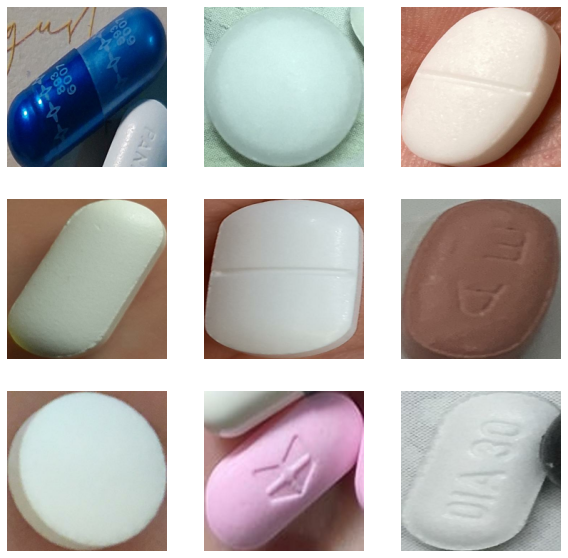

In [14]:
import matplotlib.pyplot as plt
check_image = tf.data.Dataset.from_tensor_slices(data['pill_path']).map(image_d)
plt.figure(figsize=(10, 10))
for i, img in enumerate(check_image.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    img = img/255.0
    plt.imshow(img)
    plt.axis("off")

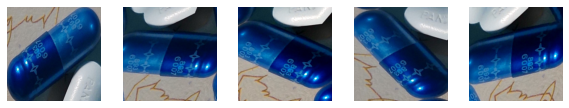

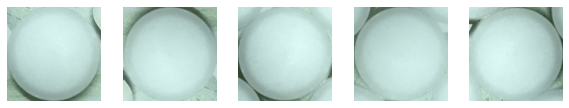

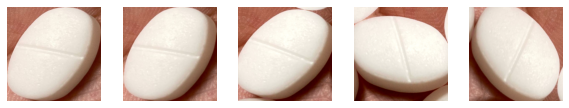

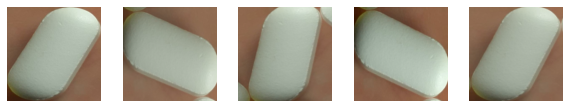

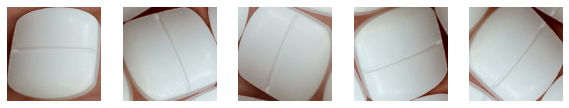

In [15]:
import numpy as np

for j,img in enumerate(check_image.take(5)):
  plt.figure(figsize=(10, 10))
  plt.subplot(5, 5, j*5+1)
  plt.imshow(img/255.0)
  plt.axis("off")
  for i in range(1,5):
      plt.subplot(5, 5, j*5+i + 1)
      augmented_image = data_augmentation(
          tf.expand_dims(img, 0), training=True
      )
      plt.imshow(augmented_image[0].numpy().astype("int32")/255.0)
      plt.axis("off")
plt.show()

# Create model

In [22]:
model, right_base_model =create_model()
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['sequential[1][0]']             
 icingOpLambda)                                                                                   
                                                                                            

In [17]:
# # output model.png
# plot_model = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True,  to_file='model.png',)

## TRain


In [18]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/gdrive/MyDrive/AI4VN/VAIPE FINAL CODE/CLASS_MODELS/{model_name}/checkpoint',
                                                 save_weights_only=True,
                                                 verbose=0)

In [19]:
# restore from checkpoint
# model.load_weights('/content/gdrive/MyDrive/AI4VN/class_run/resnet5020220817-095917/checkpoint')

Warm up clasification part

In [23]:
model.fit(
	train_dataset,
	# validation_data=val_dataset,
	epochs=10, 
	callbacks=[callback]
	)

Epoch 1/10
513/513 [==============================] - 116s 199ms/step - loss: 1.0797 - accuracy: 0.7243
Epoch 2/10
513/513 [==============================] - 106s 193ms/step - loss: 0.3544 - accuracy: 0.8934
Epoch 3/10
513/513 [==============================] - 105s 191ms/step - loss: 0.2337 - accuracy: 0.9262
Epoch 4/10
513/513 [==============================] - 105s 191ms/step - loss: 0.1763 - accuracy: 0.9453
Epoch 5/10
513/513 [==============================] - 105s 192ms/step - loss: 0.1471 - accuracy: 0.9514
Epoch 6/10
513/513 [==============================] - 105s 192ms/step - loss: 0.1297 - accuracy: 0.9573
Epoch 7/10
513/513 [==============================] - 106s 193ms/step - loss: 0.1144 - accuracy: 0.9623
Epoch 8/10
513/513 [==============================] - 105s 192ms/step - loss: 0.1139 - accuracy: 0.9614
Epoch 9/10
513/513 [==============================] - 106s 193ms/step - loss: 0.1026 - accuracy: 0.9651
Epoch 10/10
513/513 [==============================] - 105s 192m

## Fine tunning


In [24]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/gdrive/MyDrive/AI4VN/VAIPE FINAL CODE/CLASS_MODELS/{model_name}/finetune_checkpoint',
                                                 save_weights_only=True,
                                                 verbose=0)

In [25]:
right_base_model.trainable = True
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4),  # Low learning rate
              metrics=["accuracy"]
              )
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 224, 224, 3)  0          ['sequential[1][0]']             
 icingOpLambda)                                                                                   
                                                                                            

In [ ]:
model.fit(
	train_dataset,
	# validation_data=val_dataset,
	epochs=90, 
	callbacks=[callback]
	)

Epoch 1/50
513/513 [==============================] - 234s 437ms/step - loss: 0.0166 - accuracy: 0.9939
Epoch 2/50
513/513 [==============================] - 236s 446ms/step - loss: 0.0127 - accuracy: 0.9961
Epoch 3/50
513/513 [==============================] - 231s 437ms/step - loss: 0.0175 - accuracy: 0.9945
Epoch 4/50
513/513 [==============================] - 231s 437ms/step - loss: 0.0152 - accuracy: 0.9951
Epoch 5/50
513/513 [==============================] - 231s 437ms/step - loss: 0.0121 - accuracy: 0.9961
Epoch 6/50
513/513 [==============================] - 232s 439ms/step - loss: 0.0148 - accuracy: 0.9957
Epoch 7/50
477/513 [==========================>...] - ETA: 15s - loss: 0.0169 - accuracy: 0.9947

In [27]:
model.save(f'/content/gdrive/MyDrive/AI4VN/VAIPE FINAL CODE/CLASS_MODELS/{model_name}/model.h5')
print('save model:',model_name)

save model: resnet50-bb-trainall20220830-104916
